In [11]:
#@title import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import numpy as np
import random
import torch.nn.functional as F

# Set seeds for reproducibility
SEED = 41
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Machine Unlearning on a MNIST classifier - BASELINE test

## Setup

In [2]:
#@title define the neural network

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28) # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NN()

In [ ]:
#@title loading and preprocessing data

# Define transformations for the training and validation data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

## Initial Training
To begin, we'll train a neural network to classify the MNIST dataset. This section covers the steps from setting up environment to evaluating the model's accuracy. If you prefer, you can skip this section and use the pre-trained model from the GitHub repository (instructions for downloading are in the next section).

In [ ]:
#@title define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
#@title train the network

n_epochs = 10
for epoch in tqdm(range(n_epochs)):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f' Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

In [ ]:
#@title evaluate the network

correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Accuracy on the test set: 94.9%


In [ ]:
#@title save the model

joblib.dump(model, "MNIST_Classifier.joblib")

['MNIST_Classifier.joblib']

In [41]:
#@title download the pre-trained model from GitHub (if you skipped the previous section)
!wget -O MNIST_Classifier.joblib 'https://github.com/mich1803/Yesterday-Machine-Unlearning/raw/main/saved%20models/MNIST_Classifier.joblib'
model = joblib.load('MNIST_Classifier.joblib')

--2024-06-16 10:01:58--  https://github.com/mich1803/Yesterday-Machine-Unlearning/raw/main/saved%20models/MNIST_Classifier.joblib
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mich1803/Yesterday-Machine-Unlearning/main/saved%20models/MNIST_Classifier.joblib [following]
--2024-06-16 10:01:58--  https://raw.githubusercontent.com/mich1803/Yesterday-Machine-Unlearning/main/saved%20models/MNIST_Classifier.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440459 (430K) [application/octet-stream]
Saving to: ‘MNIST_Classifier.joblib’

MNIST_Classifier.jo 100%[===================>] 430.14K  --.-KB

## Unlearning

### Identify the parameters (weights and biases) most involved in the prediction of a specific class.

In [42]:
trainUNloader = DataLoader(trainset, batch_size=500, shuffle=True)
for images, label in trainUNloader:
  x = images
  break

In [43]:
import torch
import torch.nn.functional as F

# Assicurati che il modello sia in modalità di valutazione
model.eval()

# Calcola i logits in output
logits = model(x)

# Applica softmax per ottenere le probabilità
probs = F.softmax(logits, dim=1)

# Estrai la probabilità per la classe 6
class_6_prob = probs[:, 6]

# Backpropaga per calcolare i gradienti rispetto ai parametri del modello
model.zero_grad()  # Pulisci i gradienti esistenti
class_6_prob.mean().backward()  # Usa la media per aggregare sul batch

# Crea una lista per memorizzare i gradienti dei singoli parametri
param_grads = []

# Accedi ai gradienti e calcola la magnitudine per ogni parametro
for name, param in model.named_parameters():
    if param.requires_grad:
        grads = param.grad.view(-1)  # Flattens the gradients to 1D
        for i, grad in enumerate(grads):
            param_grads.append((name, i, grad.abs().item()))

# Ordina i parametri per magnitudine dei gradienti
param_grads.sort(key=lambda x: x[2], reverse=True)

# Stampa i top N parametri con i gradienti più alti
N = 250  # Puoi cambiare N per vedere più o meno parametri
top_params = param_grads[:250]

In [51]:
for param in model.parameters():
    param.requires_grad = False

# Mappa i parametri sbloccati in base al layer
param_masks = {}
for name, index, grad in top_params:
    layer_name, param_type = name.split('.')
    if (layer_name, param_type) not in param_masks:
        layer = getattr(model, layer_name)
        param = getattr(layer, param_type)
        mask = torch.zeros_like(param, dtype=torch.bool)
        param_masks[(layer_name, param_type)] = mask
    param_masks[(layer_name, param_type)].view(-1)[index] = True

# Sblocca solo i top 250 parametri più rilevanti a livello di layer
for (layer_name, param_type), mask in param_masks.items():
    layer = getattr(model, layer_name)
    param = getattr(layer, param_type)
    param.requires_grad = True

# Verifica quali parametri sono stati sbloccati
trainable_params = [param for param in model.parameters() if param.requires_grad]
if not trainable_params:
    raise ValueError("Nessun parametro allenabile è stato trovato. Verifica il calcolo dei gradienti e il processo di selezione dei parametri.")

# Redefine optimizer for the fine-tuning process
optimizer = optim.SGD(trainable_params, lr=0.01)

### Fine-Tuning

#### LOSS: Changing the original labels

In [52]:
# Define a custom loss function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, labels):
        # Create a modified version of labels where 6 is replaced by 3
        modified_labels = torch.where(labels == 6, 3, labels)
        loss = self.cross_entropy(outputs, modified_labels)
        return loss

criterion = CustomLoss()

In [53]:
# Fine-tune the network
model.train()

n_epochs = 2
for epoch in range(n_epochs):
    running_loss = 0.0
    for images, labels in tqdm(trainloader, desc = f"epoch: {epoch + 1}. "):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Fine-tuning Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')


epoch: 1. : 100%|██████████| 938/938 [00:18<00:00, 50.52it/s]


Fine-tuning Epoch 1, Loss: 0.2127962269500565


epoch: 2. : 100%|██████████| 938/938 [00:19<00:00, 47.94it/s]

Fine-tuning Epoch 2, Loss: 0.17655596349920546


In [54]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set after fine-tuning: {100 * correct / total}%')


Accuracy on the test set after fine-tuning: 85.72%


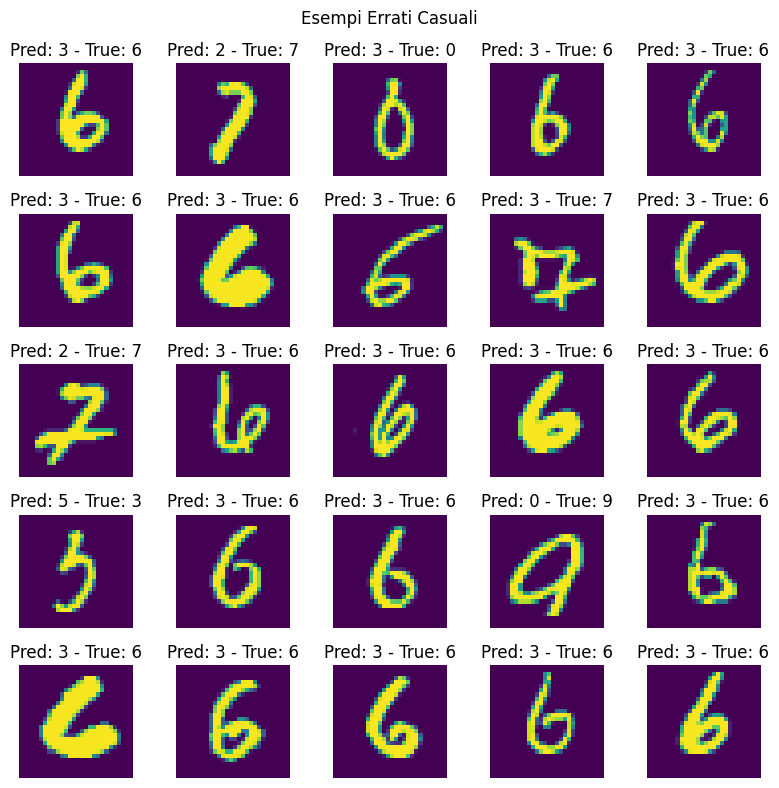

In [55]:
misclassified_images = []
misclassified_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # Trova gli indici degli errori
        misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in misclassified_idx:
            misclassified_images.append(images[idx].cpu())
            misclassified_labels.append(predicted[idx].cpu())
            true_labels.append(labels[idx].cpu())

num_samples = min(25, len(misclassified_images))
random_indices = np.random.choice(len(misclassified_images), num_samples, replace=False)

# Impostare la griglia 5x5
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Esempi Errati Casuali')

# Iterare sugli indici selezionati per visualizzare le immagini
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    img = misclassified_images[idx]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'Pred: {misclassified_labels[idx].item()} - True: {true_labels[idx].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [56]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels == 6
        if mask.sum() == 0:
            continue #if there are no 6, skip this batch

        images_6 = images[mask]
        labels_6 = labels[mask]
        outputs = model(images_6)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_6.size(0)
        correct += (predicted == labels_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on immagini with label 6: {accuracy:.2f}%')


Accuracy on immagini with label 6: 0.00%


In [57]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels != 6
        if mask.sum() == 0:
            continue

        images_not_6 = images[mask]
        labels_not_6 = labels[mask]

        outputs = model(images_not_6)
        _, predicted = torch.max(outputs.data, 1)

        total += labels_not_6.size(0)
        correct += (predicted == labels_not_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on images with other labels (not 6): {accuracy:.2f}%')


Accuracy on images with other labels (not 6): 94.80%


In [59]:
joblib.dump(model, "MINST_Classifier_unl6_labels.joblib")

['MINST_Classifier_unl6_labels.joblib']

#### LOSS: Penalyzing class 6